In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import pickle

In [5]:
df = pd.read_csv("churn.csv")
df.head()

,Unnamed: 0,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,0,106473,15639576,Sarratt,652.0,France,Female,65.0,3,0.00,2,1,1,136592.24,0
1,1,62345,15769582,Hanson,464.0,France,Male,35.0,4,0.00,1,0,0,99505.75,1
2,2,126615,15675888,Austin,620.0,Germany,Female,39.0,6,129401.87,2,1,1,102681.32,1
3,3,35909,15786617,Tuan,598.0,France,Female,30.0,7,0.00,2,1,0,141210.18,0
4,4,45175,15757310,Li Fonti,682.0,Germany,Female,46.0,4,107720.57,1,0,0,93832.33,1


# Initial Checking

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41259 entries, 0 to 41258
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       41259 non-null  int64  
 1   id               41259 non-null  int64  
 2   CustomerId       41259 non-null  int64  
 3   Surname          41259 non-null  object 
 4   CreditScore      41251 non-null  float64
 5   Geography        41259 non-null  object 
 6   Gender           41259 non-null  object 
 7   Age              41259 non-null  float64
 8   Tenure           41259 non-null  int64  
 9   Balance          41259 non-null  float64
 10  NumOfProducts    41259 non-null  int64  
 11  HasCrCard        41259 non-null  int64  
 12  IsActiveMember   41259 non-null  int64  
 13  EstimatedSalary  41259 non-null  float64
 14  churn            41259 non-null  int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 4.7+ MB


there're null values in CreditScore column

### checking duplicated values

In [18]:
df.duplicated().sum()

0

there're no duplicated values

### removing some unecessary columns

In [6]:
df.drop(columns=["Unnamed: 0","id","CustomerId","Surname"], inplace=True)
df.head()  

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,652.0,France,Female,65.0,3,0.00,2,1,1,136592.24,0
1,464.0,France,Male,35.0,4,0.00,1,0,0,99505.75,1
2,620.0,Germany,Female,39.0,6,129401.87,2,1,1,102681.32,1
3,598.0,France,Female,30.0,7,0.00,2,1,0,141210.18,0
4,682.0,Germany,Female,46.0,4,107720.57,1,0,0,93832.33,1


### cardinality checking

In [7]:
discrete = ["Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember", "churn"]
object = [col for col in df.select_dtypes("object").columns]
disc_obj = discrete + object

unique = [df[name].value_counts() for name in disc_obj]
unique

[Tenure
 2     4588
 4     4442
 7     4431
 5     4291
 8     4232
 3     4231
 1     4177
 9     4173
 6     3970
 10    1474
 0     1250
 Name: count, dtype: int64,
 NumOfProducts
 2    21132
 1    19316
 3      694
 4      117
 Name: count, dtype: int64,
 HasCrCard
 1    31126
 0    10133
 Name: count, dtype: int64,
 IsActiveMember
 0    20767
 1    20492
 Name: count, dtype: int64,
 churn
 0    32540
 1     8719
 Name: count, dtype: int64,
 Geography
 France     23520
 Spain       9081
 Germany     8658
 Name: count, dtype: int64,
 Gender
 Male      23166
 Female    18093
 Name: count, dtype: int64]

- there's no typo
- from here we can see that there're some imbalance in variables "HasCrCard" and "churn"

### checking some error values by its range
eg: error values like negative values for column "Age"

In [7]:
numeric = [col for col in df.select_dtypes("number").columns]

for col in numeric:
    print(f"the range of col-{col} uis between {df[col].min()} to {df[col].max()}")
    
#there's no error value

the range of col-CreditScore uis between 350.0 to 850.0
the range of col-Age uis between 18.0 to 92.0
the range of col-Tenure uis between 0 to 10
the range of col-Balance uis between 0.0 to 250898.09
the range of col-NumOfProducts uis between 1 to 4
the range of col-HasCrCard uis between 0 to 1
the range of col-IsActiveMember uis between 0 to 1
the range of col-EstimatedSalary uis between 11.58 to 199992.48
the range of col-churn uis between 0 to 1


### Checking Outliers
i dont include both of the imbalance variables bcs it will detect that the minority values are all outliers

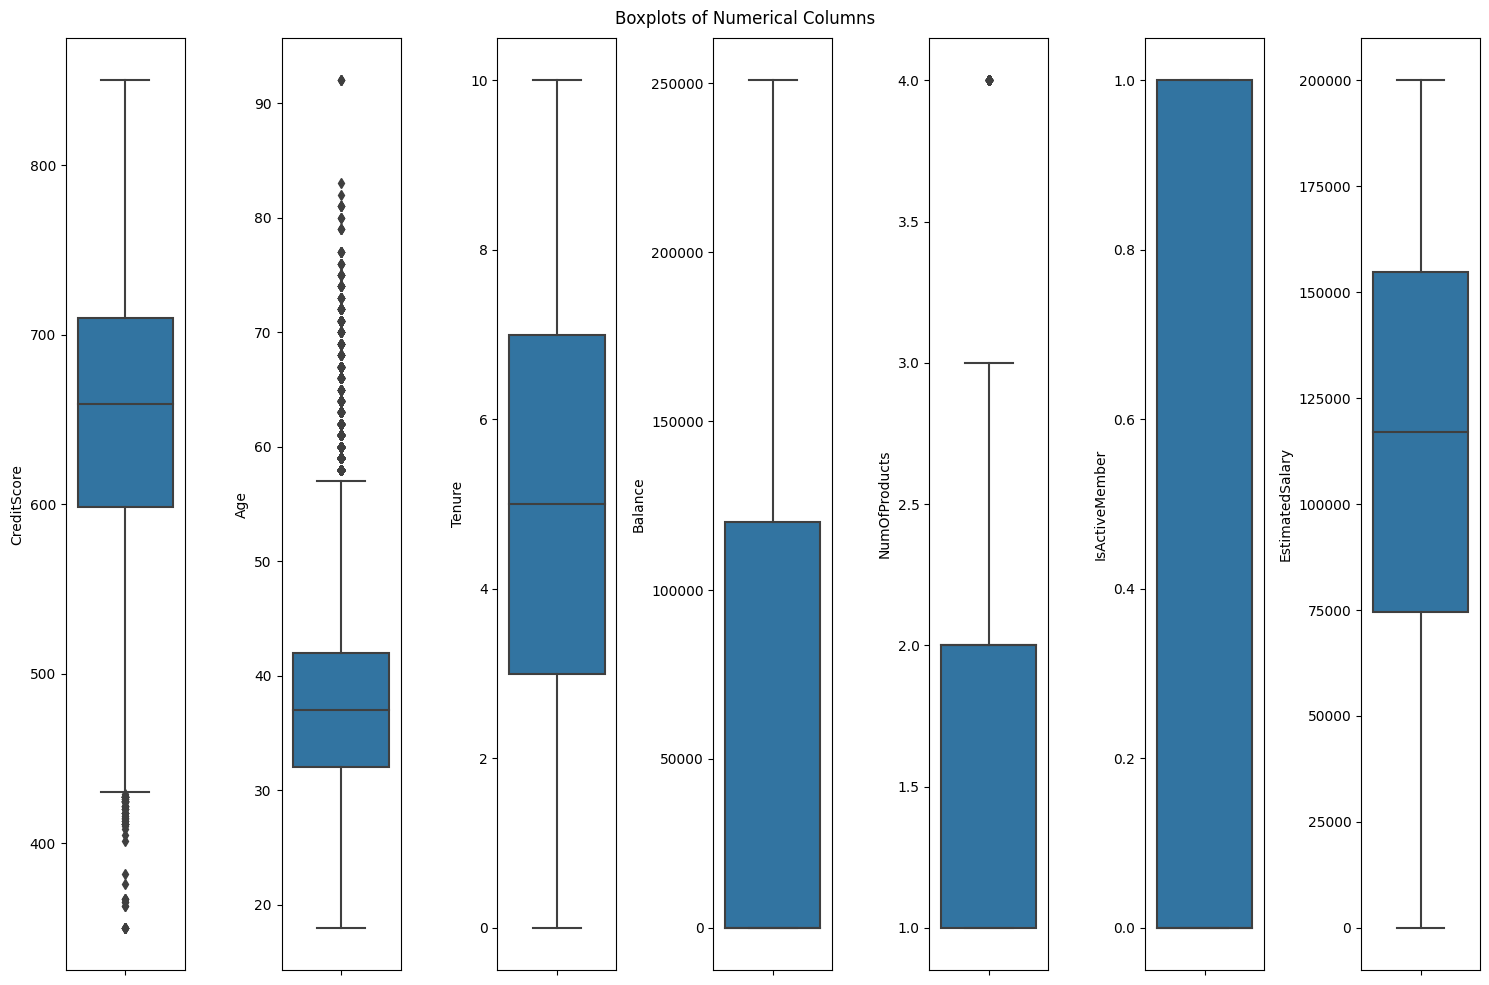

In [23]:
outliers_cols = [col for col in df.select_dtypes("number").columns if col not in ["HasCrCard","churn"]]
fig, axes = plt.subplots(1,len(outliers_cols),figsize=(15,10))
axes = axes.flatten()
for ax, col in zip(axes, outliers_cols):
    sns.boxplot(data =df, y=col, ax=ax)

for ax in axes[len(outliers_cols):]:
    ax.axis('off')

fig.suptitle("Boxplots of Numerical Columns")
plt.tight_layout()

In [24]:
df_clean = df.copy()

for col in outliers_cols:
    if col not in ["HasCrCard","churn"]:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        IQR = q3 - q1
        outliers = df[(df[col] < (q1- 1.5*IQR)) | (df[col] > (q3 + 1.5*IQR))]
        df_clean = df_clean[~df_clean.index.isin(outliers.index)]
        print(f"{col}: {len(outliers)}")

print(f"total number of the outliers is {len(df)-len(df_clean)}")

CreditScore: 76
Age: 1560
Tenure: 0
Balance: 0
NumOfProducts: 117
IsActiveMember: 0
EstimatedSalary: 0
total number of the outliers is 1735


In [10]:
len(df_clean)

39524

Given the large number of outliers in the dataset, I won't transform or delete them to avoid losing valuable information. Instead, I'll use a Robust Scaler for scaling, as it’s designed to handle outliers effectively without being influenced by them.

# Data Transformation
Data transformation is performed separately on x_train and x_test after splitting the dataset. This ensures that no information from the test set leaks into the training process, maintaining the integrity of the model’s evaluation.

## Splitting Set

In [8]:
input_df = df.drop(columns="churn")
output_df = df["churn"]

x_train,x_test,y_train,y_test = train_test_split(input_df, output_df, test_size=0.2, random_state=0)
print(x_train.size)
print(x_test.size)

330070
82520


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41259 entries, 0 to 41258
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      41251 non-null  float64
 1   Geography        41259 non-null  object 
 2   Gender           41259 non-null  object 
 3   Age              41259 non-null  float64
 4   Tenure           41259 non-null  int64  
 5   Balance          41259 non-null  float64
 6   NumOfProducts    41259 non-null  int64  
 7   HasCrCard        41259 non-null  int64  
 8   IsActiveMember   41259 non-null  int64  
 9   EstimatedSalary  41259 non-null  float64
 10  churn            41259 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 3.5+ MB


there're some null values in CreditScore column

In [9]:
x_train['CreditScore'] = x_train['CreditScore'].fillna(x_train['CreditScore'].mode()[0])
x_test['CreditScore'] = x_test['CreditScore'].fillna(x_test['CreditScore'].mode()[0])

# Features Encoding

In [28]:
object

['Geography', 'Gender']

Because all these object values are nominal variables without an inherent order, the suitable encoder is the OneHotEncoder.

In [10]:
x_train = x_train.reset_index(drop=True)
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_features = one_hot_encoder.fit_transform(x_train[object])
x_train_encoded = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(object))
x_train_encoded = pd.concat([x_train, x_train_encoded], axis=1).drop(object, axis=1)

x_test = x_test.reset_index(drop=True)
encoded_features = one_hot_encoder.transform(x_test[object])
x_test_encoded = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(object))
x_test_encoded = pd.concat([x_test, x_test_encoded], axis=1).drop(object, axis=1)

drop="first" drops the first category of each feature when creating new columns. This prevents creating too many columns, which can lead to issues like duplicate information.  Since we drop the first category, the total number of columns created for each categorical feature will be n-1, where n is the number of unique categories in that feature. This keeps things efficient without losing important information.



In [11]:
x_train_encoded.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,681.0,35.0,6,0.00,1,1,0,159463.70,0.0,0.0,0.0
1,727.0,58.0,9,103417.74,1,1,1,60988.21,0.0,0.0,1.0
2,661.0,34.0,1,0.00,2,0,0,185555.63,0.0,0.0,0.0


In [12]:
x_test_encoded.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,697.0,62.0,8,115062.61,1,1,0,23305.01,1.0,0.0,0.0
1,731.0,41.0,6,135919.33,1,1,0,95583.94,1.0,0.0,0.0
2,778.0,25.0,8,157929.52,1,1,0,29333.06,0.0,1.0,0.0


In [13]:
encoder_file = 'encoder.pkl'
pickle.dump(one_hot_encoder, open(encoder_file, 'wb'))

## Scalling

In [11]:
scaler = RobustScaler()

x_train_scaled = scaler.fit_transform(x_train_encoded)
x_test_scaled = scaler.transform(x_test_encoded)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train_encoded.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test_encoded.columns)

In [24]:
x_train_scaled.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,0.196429,-0.2,0.25,0.00000,-1.0,0.0,0.0,0.527496,0.0,0.0,-1.0
1,0.607143,2.1,1.00,0.86052,-1.0,0.0,1.0,-0.694387,0.0,0.0,0.0
2,0.017857,-0.3,-1.00,0.00000,0.0,-1.0,0.0,0.851245,0.0,0.0,-1.0


In [25]:
x_test_scaled.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,0.339286,2.5,0.75,0.957415,-1.0,0.0,0.0,-1.161960,1.0,0.0,-1.0
1,0.642857,0.4,0.25,1.130960,-1.0,0.0,0.0,-0.265124,1.0,0.0,-1.0
2,1.062500,-1.2,0.75,1.314102,-1.0,0.0,0.0,-1.087164,0.0,1.0,-1.0


In [12]:
scaler_file = 'scaler.pkl'
pickle.dump(scaler, open(scaler_file, 'wb'))

# Making models

In [16]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


In [17]:
model1 = RandomForestClassifier()
model1 = model1.fit(x_train_scaled, y_train)
y_predict = model1.predict(x_test_scaled)

print("Classfication Report\n", classification_report(y_test, y_predict))

Classfication Report
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      6499
           1       0.69      0.53      0.60      1753

    accuracy                           0.85      8252
   macro avg       0.79      0.73      0.75      8252
weighted avg       0.84      0.85      0.84      8252



In [43]:
model2 = XGBClassifier()
model2 = model2.fit(x_train_scaled, y_train)
y_predict = model2.predict(x_test_scaled)

print("Classfication Report\n", classification_report(y_test, y_predict))

Classfication Report
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      6499
           1       0.70      0.55      0.62      1753

    accuracy                           0.86      8252
   macro avg       0.79      0.74      0.76      8252
weighted avg       0.85      0.86      0.85      8252



In [42]:
model3 = GradientBoostingClassifier()
model3 = model3.fit(x_train_scaled, y_train)
y_predict = model3.predict(x_test_scaled)

print("Classfication Report\n", classification_report(y_test, y_predict))

Classfication Report
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      6499
           1       0.74      0.54      0.62      1753

    accuracy                           0.86      8252
   macro avg       0.81      0.74      0.77      8252
weighted avg       0.85      0.86      0.85      8252



In [41]:
model4 = LogisticRegression()
model4 = model4.fit(x_train_scaled, y_train)
y_predict = model4.predict(x_test_scaled)

print("Classfication Report\n", classification_report(y_test, y_predict))

Classfication Report
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      6499
           1       0.68      0.37      0.48      1753

    accuracy                           0.83      8252
   macro avg       0.76      0.66      0.69      8252
weighted avg       0.81      0.83      0.81      8252



- Both model2 and model3 yield the same accuracy, but the model with Gradient Descent Classifier (GDC) has a slightly higher F1-score for class 0.
- Given the imbalance in the dataset, the F1-score is the most appropriate metric for evaluating model performance. Therefore, model2 with GDC is the best performing model so far.
- To increase the F1 score, consider the following strategies:
Tune Hyperparameters: Optimize model parameters to improve performance.
Resampling: Apply techniques like oversampling the minority class or using SMOTE to balance class distribution and enhance model sensitivity.

# Tunning Parameters

In [36]:
params = {
    'n_estimators': [100, 200], 
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
}
tuning= GridSearchCV(GradientBoostingClassifier(),
                            param_grid = params,   
                            scoring='f1',       
                            cv=5)  
tuning.fit(x_train_scaled,y_train)
print("Tuned Hyperparameters :", tuning.best_params_)
print("f1-score :",tuning.best_score_)

Tuned Hyperparameters : {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
f1-score : 0.6319502681870579


In [38]:
model3_tun = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, min_samples_leaf= 4, min_samples_split= 2, n_estimators= 100)
model3_tun  = model3_tun .fit(x_train_scaled, y_train)
y_predict = model3_tun .predict(x_test_scaled)

print("Classfication Report\n", classification_report(y_test, y_predict))

Classfication Report
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      6499
           1       0.73      0.56      0.63      1753

    accuracy                           0.86      8252
   macro avg       0.81      0.75      0.77      8252
weighted avg       0.85      0.86      0.85      8252



In [46]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

model3_tun_smote = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, min_samples_leaf= 4, min_samples_split= 2, n_estimators= 100)
model3_tun_smote  = model3_tun_smote .fit(x_train_smote, y_train_smote)
y_predict = model3_tun_smote .predict(x_test_scaled)

print("Classfication Report\n", classification_report(y_test, y_predict))

Classfication Report
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      6499
           1       0.63      0.67      0.65      1753

    accuracy                           0.85      8252
   macro avg       0.77      0.78      0.77      8252
weighted avg       0.85      0.85      0.85      8252



## CONCLUSION:

Tuning parameters alone did not significantly improve the F1 score for both classes. However, applying SMOTE with parameter tuning resulted in a slight increase in the F1 score for the minority class.